In [166]:
import sys
sys.path.append('../1_format/')
sys.path.append('../2_analyse/')

In [167]:
import pandas as pd
import requests
import gzip
import json
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn
import numpy as np
import glob
import geopandas
from matplotlib.pyplot import figure
seaborn.set()

from parcelles import parcelles_format

In [168]:
pd.set_option('display.max_columns', None)

### Format BODACC SIREN

In [169]:
df_bodacc = pd.read_csv('../0_data/annonces-commerciales.csv', 
                        usecols=['id', 'dateparution', 'numeroannonce', 'jugement', 'numerodepartement', 'region_nom_officiel',
                                 'tribunal', 'commercant', 'ville', 'registre'],
                        sep=';')

In [170]:
len(df_bodacc)

2714284

In [171]:
# get jugement info
df_bodacc['jugement_nature'] = df_bodacc['jugement'].apply(lambda x: json.loads(x)['nature'])
df_bodacc['jugement_famille'] = df_bodacc['jugement'].apply(lambda x: json.loads(x)['famille'])
df_bodacc['jugement_date'] = df_bodacc['jugement'].apply(lambda x: json.loads(x)['date'] if 'date' in json.loads(x) else '')
df_bodacc['jugement_complement'] = df_bodacc['jugement'].apply(lambda x: json.loads(x)['complementJugement'] if 'complementJugement' in json.loads(x) else '')
df_bodacc = df_bodacc.drop('jugement', axis=1)

In [172]:
# get rid of null siren with no info
df_bodacc = df_bodacc.dropna(subset='registre')
df_bodacc['registre'] = df_bodacc['registre'].astype(str)
df_bodacc['registre'] = df_bodacc['registre'].apply(lambda x : x.replace('000 000 000,000000000,', ''))
df_bodacc = df_bodacc[df_bodacc['registre'] != '000 000 000,000000000']

In [173]:
len(df_bodacc)

2439551

In [174]:
# aggregated rows ??? mixed commercant name and registre with no link 
'''
len_reg = df_bodacc['registre'].apply(lambda x : len(x))
df_bodacc_agg = df_bodacc[df_bodacc.index.isin(list(len_reg[len_reg != 21].index))]
df_bodacc_agg['registre'] = df_bodacc_agg['registre'].str.split(',')
df_bodacc_agg = df_bodacc_agg.explode('registre')
df_bodacc_agg['registre'] = df_bodacc_agg['registre'].apply(lambda x: x.replace(' ', ''))
df_bodacc_agg = df_bodacc_agg.drop_duplicates()
'''

"\nlen_reg = df_bodacc['registre'].apply(lambda x : len(x))\ndf_bodacc_agg = df_bodacc[df_bodacc.index.isin(list(len_reg[len_reg != 21].index))]\ndf_bodacc_agg['registre'] = df_bodacc_agg['registre'].str.split(',')\ndf_bodacc_agg = df_bodacc_agg.explode('registre')\ndf_bodacc_agg['registre'] = df_bodacc_agg['registre'].apply(lambda x: x.replace(' ', ''))\ndf_bodacc_agg = df_bodacc_agg.drop_duplicates()\n"

In [175]:
#len(df_bodacc[df_bodacc.index.isin(list(len_reg[len_reg != 21].index))])

In [176]:
# extract SIREN
df_bodacc['SIREN'] = df_bodacc['registre'].apply(lambda x: x.split(',')[0].replace(' ', ''))
df_bodacc = df_bodacc.drop('registre', axis=1)

### Format BODACC date

In [194]:
df_bodacc['dateparution'] = pd.to_datetime(df_bodacc['dateparution'])
df_bodacc['jugement_date'] = pd.to_datetime(df_bodacc['jugement_date'], format='mixed', dayfirst=True, errors='ignore')

In [195]:
df_bodacc = df_bodacc.sort_values(by='dateparution')

In [196]:
len(df_bodacc.SIREN.unique())

898163

### Format BODACC Judgement

In [197]:
# fix error import
df_bodacc['jugement_famille'] = df_bodacc['jugement_famille'].replace('Jugement prononÃ§ant', 'Jugement prononçant')
df_bodacc['jugement_famille'] = df_bodacc['jugement_famille'].replace('Avis de dÃ©pÃ´t', 'Avis de dépôt')
df_bodacc['jugement_famille'] = df_bodacc['jugement_famille'].replace('Jugement de clÃ´ture', 'Jugement de clôture')
df_bodacc['jugement_famille'] = df_bodacc['jugement_famille'].replace("ArrÃªt de la Cour d'Appel", "Arrêt de la Cour d'Appel")

- **Rétraction sur tierce opposition** : on retrouve ici des rétraction pour des *redressements/liquidation judiciaire*. La tierce opposition désigne le recours exercé par un tiers au jugement lorsque le jugement est de nature à lui faire subir un préjudice. L’idée est de protéger les tiers dont les intérêts seraient menacés par une décision de justice rendue sans qu’ils aient pu défendre leurs droits. 



- **Jugement prononçant** : on retrouve ici des *jugements de conversion en liquidation judiciaire*. L’un des objectifs d’un débiteur en redressement judiciaire est d’éviter une conversion en liquidation judiciaire. En effet, c’est l’issue la plus dramatique de la vie d’une société car elle marque le début de la fin. La conversion en liquidation judiciaire peut arriver à tout moment pendant la période d’observation. Cette conversion n’est subordonnée qu’à une seule condition : l’impossibilité manifeste de redresser la société.



- **Loi de 1967** : on retrouve ici des *jugements de clôture*. A renommer dans jugements de cloture ?


- **Jugement de clôture** : on retrouve ici des *jugements de clôture pour insuffisance d'actif*.


- **Jugement d'ouverture** : on retrouve ici des *jugements de d'ouverture de liquididation judiciaire*. 


- **Extrait de jugement** : diverse. à creuser. Bcp liée à des jugements de plan de redressement (Le plan de redressement ) a pour objet de permettre à une entreprise en difficulté continuer l’exploitation de son activité tout en étalant le règlement de ses dettes sur une période maximale de 10 ans), d'interdiction de gérer ou resolution du plan de redressement et liquidation judiciaire


- **Avis de dépôt** : on retrouve ici des *Dépot de l'état des créances*. L’état des créances est déposé au greffe où il est public, et son dépôt fait l’objet d’une publicité au BODACC qui fait courir le délai de recours des tiers contre chacune des décisions rendues qui y sont regroupées. Lorsqu’une entreprise est en difficulté, une procédure collective peut être ouverte à son égard. En tant que créancier, déclarer sa créance est primordial pour pouvoir se faire payer un jour par cette entreprise en difficulté.


- **Arrêt de la Cour d'Appel** : La cour d’appel juge des litiges qui ont déjà fait l'objet d'un premier jugement.


In [198]:
df_bodacc['jugement_famille'].unique()

array(["Jugement d'ouverture", 'Jugement de clôture',
       'Extrait de jugement', 'Jugement prononçant', 'Avis de dépôt',
       'Loi de 1967', "Arrêt de la Cour d'Appel",
       'Rétractation sur tierce opposition'], dtype=object)

<Axes: ylabel='jugement_nature'>

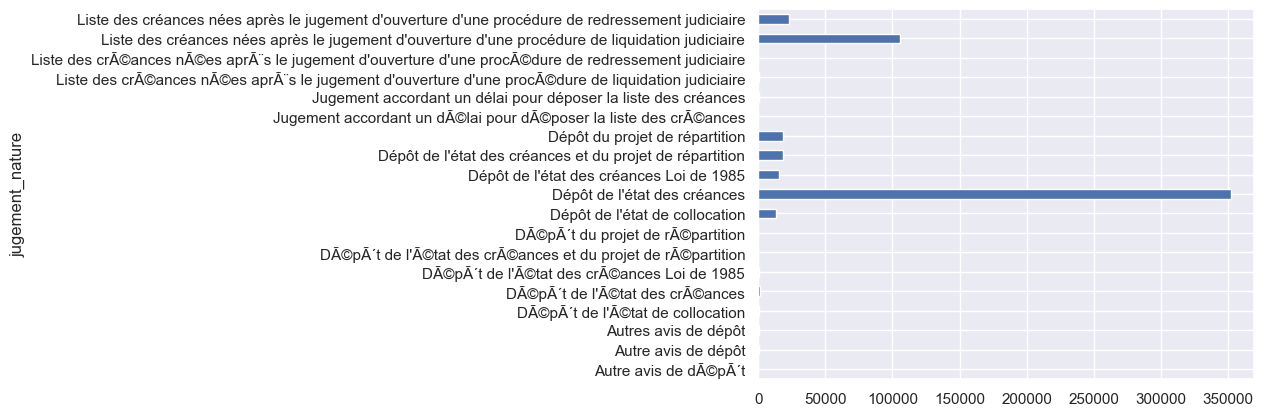

In [199]:
df_bodacc[df_bodacc['jugement_famille'] == "Avis de dépôt"].groupby('jugement_nature').count()['id'].plot(kind='barh')

In [200]:
# keep only relevant categories
df_bodacc = df_bodacc.loc[(df_bodacc['jugement_famille'] != 'Rétractation sur tierce opposition') & 
                          (df_bodacc['jugement_famille'] != 'Loi de 1967') &
                          (df_bodacc['jugement_famille'] != "Arrêt de la Cour d'Appel")]

In [201]:
# convert to simple sub categories of judgements
df_bodacc.loc[(df_bodacc['jugement_famille'] == 'Jugement prononçant') & (df_bodacc['jugement_nature'] != 'Jugement de conversion en liquidation judiciaire'), 'jugement_nature'] = 'Autre jugement'
df_bodacc.loc[(df_bodacc['jugement_famille'] == 'Jugement de clôture') & (df_bodacc['jugement_nature'] != "Jugement de clôture pour insuffisance d'actif"), 'jugement_nature'] = 'Autre jugement'
df_bodacc.loc[(df_bodacc['jugement_famille'] == "Jugement d'ouverture") & ((df_bodacc['jugement_nature'] != "Jugement d'ouverture de liquidation judiciaire") & (df_bodacc['jugement_nature'] != "Jugement d'ouverture d'une procédure de redressement judiciaire")), 'jugement_nature'] = 'Autre jugement'
df_bodacc.loc[(df_bodacc['jugement_famille'] == "Avis de dépôt") & (df_bodacc['jugement_nature'] != "Dépôt de l'état des créances"), 'jugement_nature'] = 'Autre jugement'

In [202]:
df_bodacc.loc[df_bodacc['jugement_nature'] == "Jugement d'ouverture de liquidation judiciaire", "jugement_famille"] = "Jugement d'ouverture de liquidation"
df_bodacc.loc[df_bodacc['jugement_nature'] == "Jugement d'ouverture d'une procédure de redressement judiciaire", "jugement_famille"] = "Jugement d'ouverture de redressement"
df_bodacc.loc[df_bodacc['jugement_nature'] == "Autre jugement", "jugement_famille"] = "Jugement d'ouverture autre"

### Analysis of selected perimeter : IDF appeared for the last time later than 2020

In [203]:
siren_list_idf = list(df_bodacc[(df_bodacc.dateparution > '2020-01-01') & (df_bodacc.region_nom_officiel == 'Île-de-France')].SIREN.unique())
df_bodacc_analysis = df_bodacc[df_bodacc.SIREN.isin(siren_list_idf)]

In [204]:
len(df_bodacc_analysis.SIREN.unique())

50425

### Analysis of judgement distribution

<Axes: ylabel='jugement_famille'>

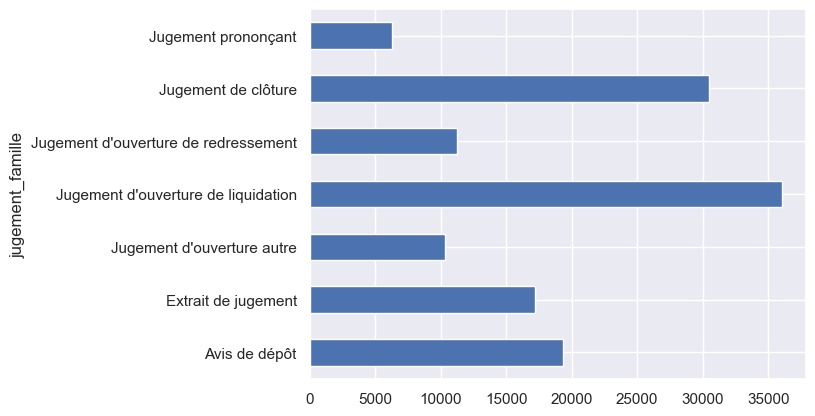

In [205]:
df_bodacc_analysis.groupby(['jugement_famille']).count().id.plot(kind='barh')

In [206]:
df_bodacc_analysis.jugement_famille.unique()

array(["Jugement d'ouverture de redressement", 'Extrait de jugement',
       "Jugement d'ouverture de liquidation",
       "Jugement d'ouverture autre", 'Jugement prononçant',
       'Avis de dépôt', 'Jugement de clôture'], dtype=object)

In [207]:
df_bodacc_analysis[df_bodacc_analysis['jugement_famille'] == "Avis de dépôt"].groupby(['jugement_nature']).count()

,id,dateparution,numeroannonce,numerodepartement,region_nom_officiel,tribunal,commercant,ville,jugement_famille,jugement_date,jugement_complement,SIREN
jugement_nature,,,,,,,,,,,,
Dépôt de l'état des créances,19354,19354,19354,19354,19354,19354,19353,19316,19354,19354,19354,19354


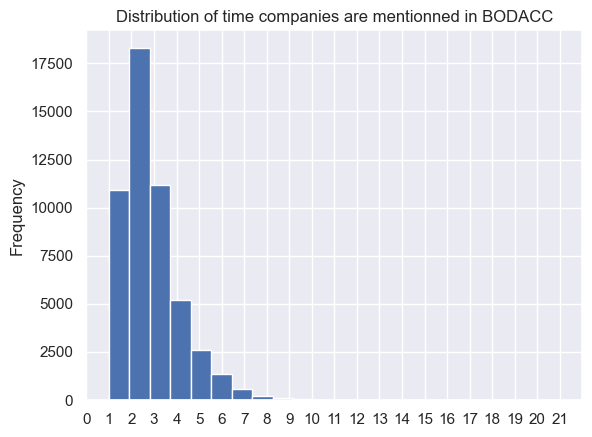

In [208]:
suivi_bodacc = df_bodacc_analysis.drop_duplicates(['SIREN', 'dateparution', 'jugement_nature'])
suivi_bodacc.groupby('SIREN').count()['dateparution'].plot.hist(bins=22, title='Distribution of time companies are mentionned in BODACC')
plt.xticks(range(0,22))
plt.show()

### Analysis of transitions

In [209]:
df_transition = df_bodacc_analysis.copy()
df_transition = df_transition.sort_values(by=['SIREN', 'dateparution'])

df_transition['jugement_prec'] = df_transition['jugement_famille'].shift(1)
df_transition['SIREN_prec'] =df_transition['SIREN'].shift(1)

df_transition.loc[df_transition['SIREN'] != df_transition['SIREN_prec'], 'jugement_prec'] = np.nan
df_transition = df_transition.reset_index(drop=True)

df_transition = df_transition[['id', 'SIREN', 'dateparution', 'jugement_prec', 'jugement_nature', 'jugement_famille',
                               'jugement_date']]

In [210]:
category_mapping = {
    "Jugement d'ouverture autre": 0,
    "Jugement d'ouverture de liquidation": 1,
    "Jugement d'ouverture de redressement": 2,
    'Extrait de jugement': 3,
    'Loi de 1967': 4,
    'Avis de dépôt': 5,
    'Jugement prononçant': 6,
    "Arrêt de la Cour d'Appel": 7,
    'Rétractation sur tierce opposition': 8,
    'Jugement de clôture': 9}
df_transition['jugement_famille'] = df_transition['jugement_famille'].replace(category_mapping)
df_transition['jugement_prec'] = df_transition['jugement_prec'].replace(category_mapping)

In [211]:
df_transition_grouped =  df_transition.groupby(['jugement_prec', 'jugement_famille']).count()['SIREN'].reset_index()

In [212]:
'''
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(category_mapping.keys()),
      color = "blue"
    ),
    link = dict(
      source = list(df_transition_grouped.jugement_prec),
      target = list(df_transition_grouped.jugement_famille),
      value = list(df_transition_grouped.SIREN)
  ))])
fig.update_layout(title_text="Transfers from one jugement to another", font_size=10)
fig.show()
'''

'\nfig = go.Figure(data=[go.Sankey(\n    node = dict(\n      pad = 15,\n      thickness = 20,\n      line = dict(color = "black", width = 0.5),\n      label = list(category_mapping.keys()),\n      color = "blue"\n    ),\n    link = dict(\n      source = list(df_transition_grouped.jugement_prec),\n      target = list(df_transition_grouped.jugement_famille),\n      value = list(df_transition_grouped.SIREN)\n  ))])\nfig.update_layout(title_text="Transfers from one jugement to another", font_size=10)\nfig.show()\n'

In [213]:
# only keep important link
df_transition_grouped_imp = df_transition_grouped[df_transition_grouped.SIREN >= 2200]

In [214]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
        
      line = dict(color = "black", width = 0.5),
      color = ["lightsteelblue", "lightsteelblue", "lightsteelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "royalblue"]
    ),
    link = dict(
      source = list(df_transition_grouped_imp.jugement_prec),
      target = list(df_transition_grouped_imp.jugement_famille),
      value = list(df_transition_grouped_imp.SIREN),
        color = 'gainsboro'
  ))])
fig.update_layout(font_size=20)
fig.show()

In [215]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      color = ["lightsteelblue", "lightsteelblue", "lightsteelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "royalblue"]
    ),
    link = dict(
      source = list(df_transition_grouped_imp.jugement_prec),
      target = list(df_transition_grouped_imp.jugement_famille),
      value = list(df_transition_grouped_imp.SIREN)
  ))])
fig.update_layout(font_size=20)
fig.show()

### Analysis length of transition from opening to closing

<Axes: title={'center': 'Last mention in BODACC'}, ylabel='jugement_famille'>

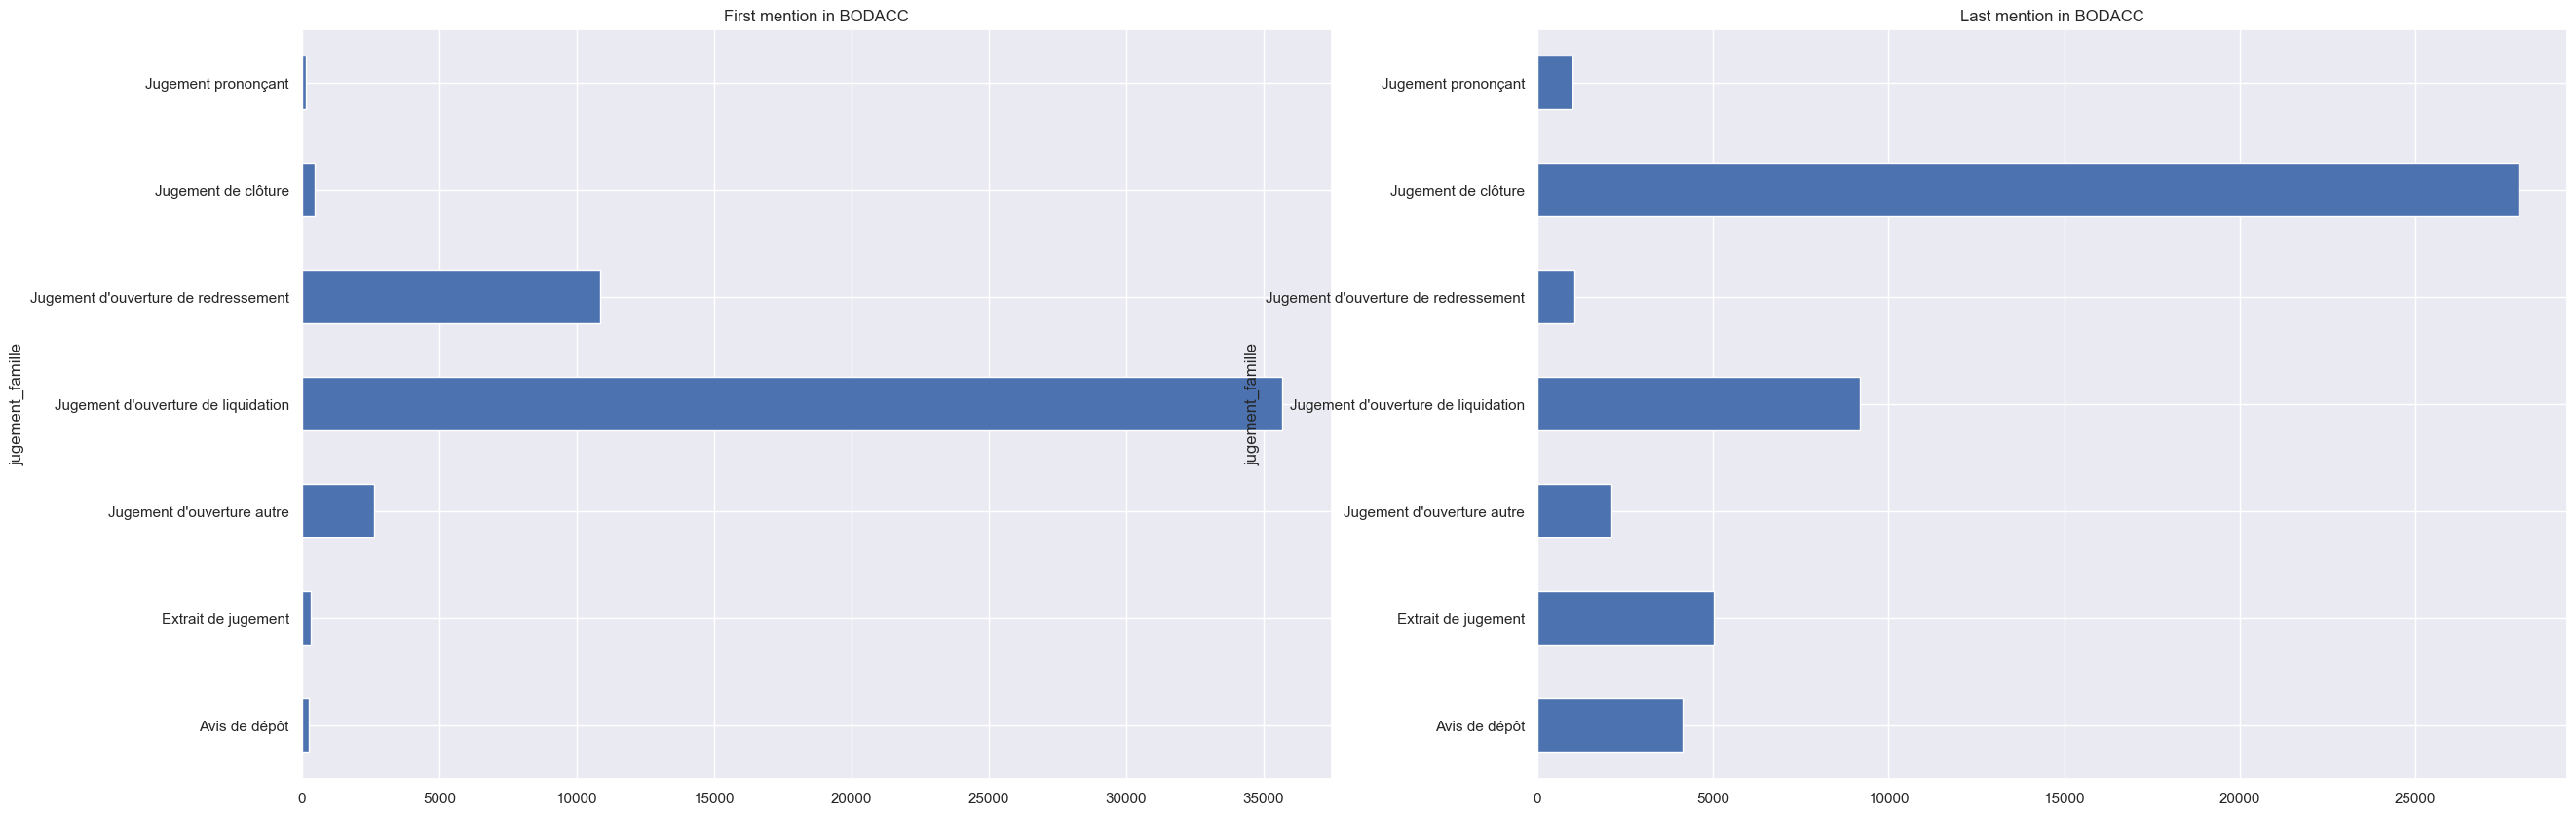

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(30,10))

df_bodacc_analysis = df_bodacc_analysis.sort_values(by=['SIREN', 'dateparution'])
df_bodacc_analysis.drop_duplicates('SIREN', keep='first').groupby(['jugement_famille']).count().id.plot(kind='barh',
                                                                                                        title='First mention in BODACC',
                                                                                                        ax=ax[0])

df_bodacc_analysis.drop_duplicates('SIREN', keep='last').groupby(['jugement_famille']).count().id.plot(kind='barh',
                                                                                                       title='Last mention in BODACC',
                                                                                                       ax=ax[1])

In [216]:
jug_ouvert = df_bodacc_analysis[df_bodacc_analysis.jugement_famille == "Jugement d'ouverture de liquidation"]
jug_ferme = df_bodacc_analysis[df_bodacc_analysis.jugement_famille == "Jugement de clôture"]
df_jug_ouverture_fermeture = jug_ouvert[['SIREN', 'jugement_date']].rename({'jugement_date': 'jugement_date_ouverture'}, axis=1).merge(jug_ferme[['SIREN', 'jugement_date']].rename({'jugement_date': 'jugement_date_fermeture'}, axis=1), how='left', left_on='SIREN', right_on='SIREN')
df_jug_ouverture_fermeture.head(5)

,SIREN,jugement_date_ouverture,jugement_date_fermeture
0,592042519,5 mai 2008,2020-01-23
1,397994914,16 octobre 2008,NaN
2,481753861,10 janvier 2008,2022-09-20
3,384262960,3 juillet 2008,2020-09-17
4,450121975,18 février 2008,2020-07-31


In [219]:
df = df_jug_ouverture_fermeture[df_jug_ouverture_fermeture.jugement_date_fermeture.isna()]

In [228]:
df = df.sort_values(by='jugement_date_ouverture')[130:]

In [237]:
df = df.sort_values(by='jugement_date_ouverture', ascending=False)[150:]

In [240]:
df = df.sort_values(by='jugement_date_ouverture')

In [242]:
print('Number of companies that started a process : ', len(df))

Number of companies that started a process :  12735


In [37]:
df_jug_ouverture_fermeture.to_csv('df_jug_ouverture_fermeture.csv', sep=';')

In [32]:
print('Number of companies still in process :', len(df_jug_ouverture_fermeture.loc[~(df_jug_ouverture_fermeture.jugement_date_ouverture.isna()) & (df_jug_ouverture_fermeture.jugement_date_fermeture.isna())]))

Number of companies still in process : 13015


In [33]:
delta_ouverture_fermeture = df_jug_ouverture_fermeture.copy()
delta_ouverture_fermeture['jugement_date_ouverture'] = pd.to_datetime(delta_ouverture_fermeture['jugement_date_ouverture'], format='mixed', dayfirst=True, errors='coerce')
delta_ouverture_fermeture['jugement_date_fermeture'] = pd.to_datetime(delta_ouverture_fermeture['jugement_date_fermeture'], format='mixed', dayfirst=True, errors='coerce')

In [34]:
delta_ouverture_fermeture = delta_ouverture_fermeture.dropna()
delta_ouverture_fermeture['delta'] = (delta_ouverture_fermeture['jugement_date_fermeture'] - delta_ouverture_fermeture['jugement_date_ouverture']).dt.days
delta_ouverture_fermeture = delta_ouverture_fermeture[(delta_ouverture_fermeture['delta'] > 0)]

In [35]:
print('avg length in days :', round(delta_ouverture_fermeture.delta.mean(),2))

avg length in days : 591.48


<Axes: title={'center': "Period between 'ouverture' et 'fermeture' in days of liquid"}, ylabel='Frequency'>

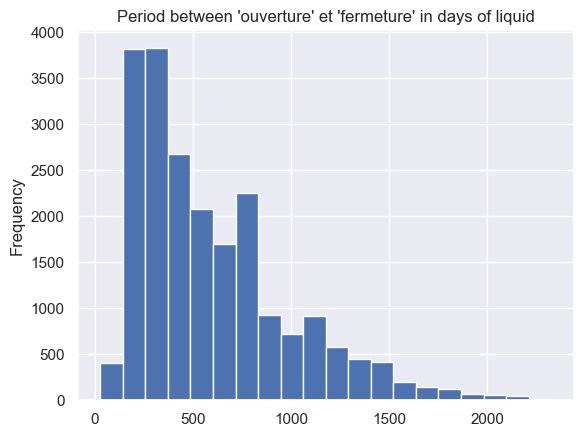

In [130]:
delta_ouverture_fermeture[delta_ouverture_fermeture['delta'] >= 0].delta.plot(kind='hist', bins=20,
                                                    title="Period between 'ouverture' et 'fermeture' in days of liquid")

In [133]:
delta_ouverture_fermeture[delta_ouverture_fermeture['delta'] >= 0].to_csv('plot.csv',sep=';')

### Link to MAJIC

In [43]:
# get SIREN of companies that are PM
SIREN = pd.read_csv('../0_data/base_sirene/StockUniteLegale_utf8.csv', 
                    usecols=['siren', 'denominationUniteLegale', 'prenom1UniteLegale'],
                    dtype = {'siren': str})
SIREN = SIREN[SIREN.prenom1UniteLegale.isna()]
df_bodacc_analysis = df_bodacc_analysis[df_bodacc_analysis.SIREN.isin(list(SIREN.siren))]

C:\Users\RémiJAYLET\AppData\Local\Temp\ipykernel_15260\1963087180.py:2: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [193]:
df_jug_ouverture

NameError: name 'df_jug_ouverture' is not defined

In [116]:
df_jug_ouverture = df_jug_ouverture_fermeture.loc[~(df_jug_ouverture_fermeture.jugement_date_ouverture.isna()) & (df_jug_ouverture_fermeture.jugement_date_fermeture.isna())]
df_jug_ouverture = df_jug_ouverture.drop_duplicates('SIREN')
df = df_jug_ouverture.loc[(df_jug_ouverture.jugement_date_ouverture < '2023-05-01')]
df = df.sort_values('jugement_date_ouverture')[120:]
df['jugement_date_ouverture'] = pd.to_datetime(df.jugement_date_ouverture, format='%Y-%m-%d')
df['month_year'] = df['jugement_date_ouverture'].dt.to_period('M')

<Axes: xlabel='month_year'>

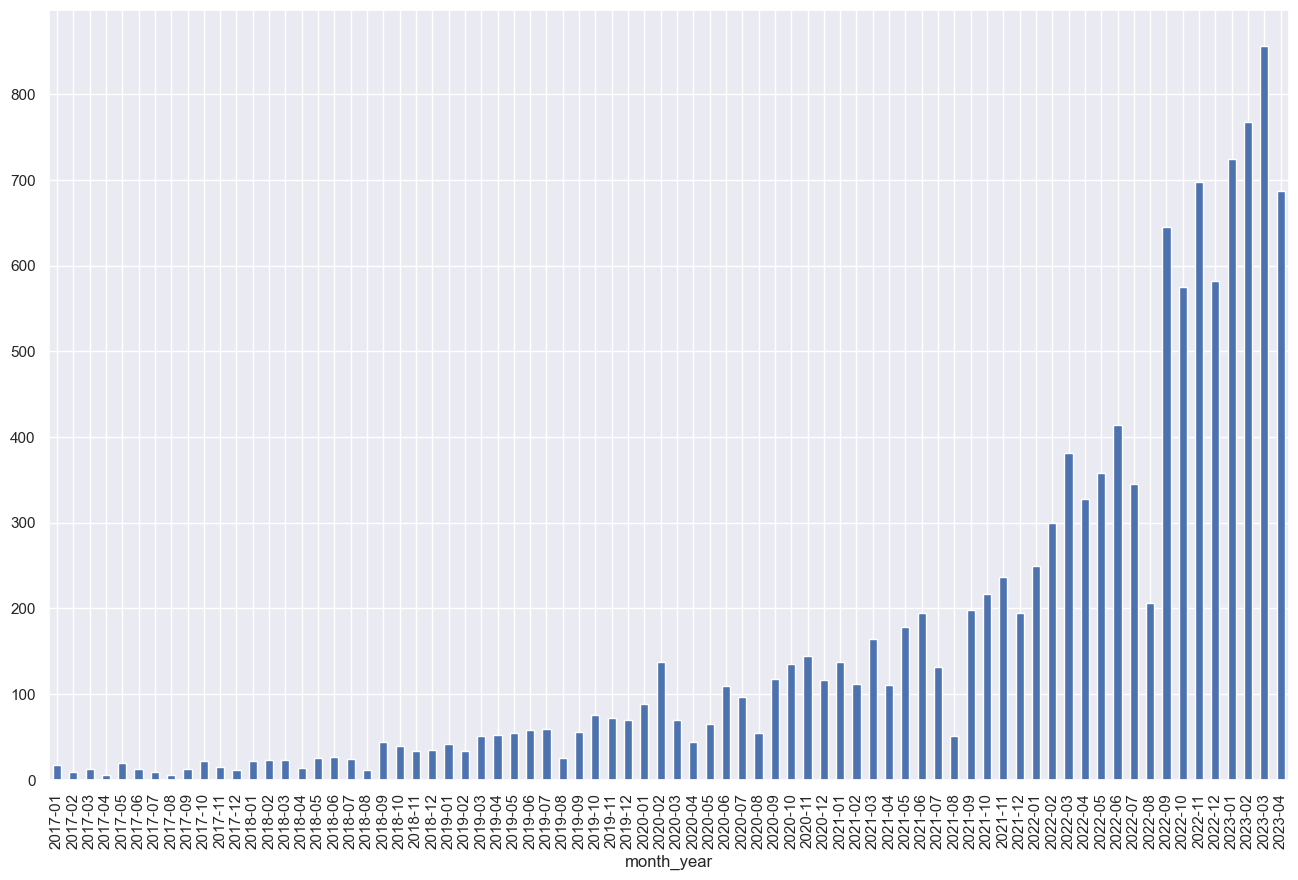

In [117]:
figure(figsize=(16, 10))

df.groupby('month_year').count()['SIREN'].plot(kind='bar')

In [57]:
jug_ouvert = df_bodacc_analysis[df_bodacc_analysis.jugement_famille == "Jugement d'ouverture de liquidation"]
jug_ferme = df_bodacc_analysis[df_bodacc_analysis.jugement_famille == "Jugement de clôture"]
df_jug_ouverture_fermeture = jug_ouvert[['SIREN', 'jugement_date']].rename({'jugement_date': 'jugement_date_ouverture'}, axis=1).merge(jug_ferme[['SIREN', 'jugement_date']].rename({'jugement_date': 'jugement_date_fermeture'}, axis=1), how='left', left_on='SIREN', right_on='SIREN')
df_jug_ouverture_fermeture = df_jug_ouverture_fermeture.drop_duplicates('SIREN')
df_jug_ouverture_fermeture.head(5)

,SIREN,jugement_date_ouverture,jugement_date_fermeture
0,300071990,2018-06-25,2020-12-11
1,300094570,2019-09-10,2021-06-09
2,300094927,17 décembre 2014,2021-11-17
3,300116035,2021-02-09,2022-10-31
4,300208568,2023-03-07,NaN


In [77]:
df = df_jug_ouverture_fermeture[df_jug_ouverture_fermeture['jugement_date_fermeture'].isna()]
df = df[df['jugement_date_ouverture']>'2022-01-01']

In [96]:
df = df.sort_values('jugement_date_ouverture', ascending=False)[120:]

In [243]:
df

,SIREN,jugement_date_ouverture,jugement_date_fermeture
2426,498800697,2016-12-01,NaN
2457,420706160,2016-12-01,NaN
2429,519690614,2016-12-01,NaN
2436,519605109,2016-12-05,NaN
2449,519188080,2016-12-07,NaN
...,...,...,...
36398,888567369,2023-04-26,NaN
36397,880640545,2023-04-26,NaN
36415,813019924,2023-04-26,NaN
36411,448200246,2023-04-26,NaN


#### PARCELLES

In [98]:
df_parc1 = pd.concat([pd.read_csv(i,
                                  sep=';',
                                  encoding='latin',
                                  low_memory=False,
                                  dtype={'Département (Champ géographique)' : str,
                                         'Code Direction (Champ géographique)' : str,
                                         'Code Commune (Champ géographique)' : str,
                                         'Préfixe (Références cadastrales)' : str,
                                         'Section (Références cadastrales)' : str,
                                         'N° plan (Références cadastrales)' : str}) for i in glob.glob(
    "../0_data/parcelles/Fichier des parcelles (situation 2022)-dept 01 à 61/Fichier des parcelles (situation 2022)-dpts 01 à 61/*.txt", recursive=True)])

df_parc2 = pd.concat([pd.read_csv(i, sep=';',
                                  encoding='latin',
                                  low_memory=False,
                                  dtype={'Département (Champ géographique)' : str,
                                         'Code Direction (Champ géographique)' : str,
                                         'Code Commune (Champ géographique)' : str,
                                         'Préfixe (Références cadastrales)' : str,
                                         'Section (Références cadastrales)' : str,
                                         'N° plan (Références cadastrales)' : str}) for i in glob.glob(
    "../0_data/parcelles/Fichier des parcelles (situation 2022)-dept 62 à 976/Fichier des parcelles (situation 2022)-dpts 62 à 976/*.txt", recursive=True)])

df_parc = pd.concat([df_parc1, df_parc2], axis=0)

In [253]:
cross_parc_bodacc = df.merge(df_parc,
                                           left_on='SIREN',
                                           right_on = 'N° SIREN (Propriétaire(s) parcelle)',
                                           how='left')

In [254]:
len(df)

12735

In [255]:
full_cross_parc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),N° de voirie (Adresse parcelle),Indice de répétition (Adresse parcelle),Code voie MAJIC (Adresse parcelle),Code voie rivoli (Adresse parcelle),Nature voie (Adresse parcelle),Nom voie (Adresse parcelle),Contenance (Caractéristiques parcelle),SUF (Evaluation SUF),Nature culture (Evaluation SUF),Contenance (Evaluation SUF),Code droit (Propriétaire(s) parcelle),N° MAJIC (Propriétaire(s) parcelle),N° SIREN (Propriétaire(s) parcelle),Groupe personne (Propriétaire(s) parcelle),Forme juridique (Propriétaire(s) parcelle),Forme juridique abrégée (Propriétaire(s) parcelle),Dénomination (Propriétaire(s) parcelle)
5,342376928,2016-12-07,NaN,75,8,105,PARIS 05,,AL,0026,11.0,NaN,163.0,7301,RUE,PESTALOZZI,142.0,NaN,S,142.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
6,342376928,2016-12-07,NaN,75,8,106,PARIS 06,,AR,0049,121.0,NaN,138.0,6838,RUE,NOTRE-DAME DES CHAMPS,301.0,NaN,S,301.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
7,342376928,2016-12-07,NaN,75,8,114,PARIS 14,,BV,0091,57.0,NaN,298.0,7256,RUE,DU PERE CORENTIN,378.0,NaN,S,378.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
8,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,BQ,0002,77.0,NaN,342.0,7140,RUE,PASTEUR,836.0,NaN,S,836.0,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
9,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,20.0,NaN,185.0,3160,AV,ERNEST RENAN,211.0,NaN,S,211.0,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12877,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,0519,NaN,NaN,48.0,B048,NaN,SALINS,607.0,NaN,T,607.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12878,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1156,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,600.0,NaN,S,600.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12879,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1163,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,9.0,NaN,S,9.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12880,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1170,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,38.0,NaN,S,38.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT


In [256]:
full_cross_parc = cross_parc_bodacc[~cross_parc_bodacc['N° SIREN (Propriétaire(s) parcelle)'].isna()]
full_cross_parc = full_cross_parc.drop_duplicates(['SIREN', 'jugement_date_ouverture', 'Département (Champ géographique)', 'Code Commune (Champ géographique)', 'Section (Références cadastrales)', 'Préfixe (Références cadastrales)', 'N° plan (Références cadastrales)'])

In [257]:
print('Number of parcelles concerned :', len(full_cross_parc))

Number of parcelles concerned : 909


In [258]:
print('Number of companies concerned :', len(full_cross_parc.SIREN.unique()))

Number of companies concerned : 128


In [267]:
full_cross_parc[full_cross_parc['Nom Commune (Champ géographique)'].isin(list_cities)]

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),N° de voirie (Adresse parcelle),Indice de répétition (Adresse parcelle),Code voie MAJIC (Adresse parcelle),Code voie rivoli (Adresse parcelle),Nature voie (Adresse parcelle),Nom voie (Adresse parcelle),Contenance (Caractéristiques parcelle),SUF (Evaluation SUF),Nature culture (Evaluation SUF),Contenance (Evaluation SUF),Code droit (Propriétaire(s) parcelle),N° MAJIC (Propriétaire(s) parcelle),N° SIREN (Propriétaire(s) parcelle),Groupe personne (Propriétaire(s) parcelle),Forme juridique (Propriétaire(s) parcelle),Forme juridique abrégée (Propriétaire(s) parcelle),Dénomination (Propriétaire(s) parcelle)
8,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,BQ,0002,77.0,NaN,342.0,7140,RUE,PASTEUR,836.0,NaN,S,836.0,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
9,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,20.0,NaN,185.0,3160,AV,ERNEST RENAN,211.0,NaN,S,211.0,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
2660,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0068,56.0,NaN,110.0,7130,RUE,DE PARIS,288.0,NaN,S,288.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS
2661,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0069,71.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,354.0,NaN,S,354.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS
2662,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0148,75.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,280.0,NaN,S,280.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS
2663,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0179,75.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,290.0,NaN,S,290.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS
3443,682024542,2021-05-12,NaN,92,1,004,ASNIERES-SUR-SEINE,,AQ,0163,17.0,NaN,304.0,6660,RUE,DE NORMANDIE,210.0,NaN,S,210.0,S,PBBPVS,682024542,0,5710,SAS,PROGESCO SA
3708,798531745,2021-06-16,NaN,94,0,002,ALFORTVILLE,,Q,0178,40.0,NaN,155.0,9621,RUE,VICTOR HUGO,302.0,NaN,S,302.0,S,PBGDMM,798531745,0,5499,SARL,SARL ADB PATRIMOINE
3713,798531745,2021-06-16,NaN,94,0,068,ST MAUR DES FOSSES,,AQ,0083,1.0,NaN,92.0,0760,AV,DE BRAZZA,561.0,NaN,S,561.0,S,PBGDMM,798531745,0,5499,SARL,SARL ADB PATRIMOINE
3714,798531745,2021-06-16,NaN,94,0,068,ST MAUR DES FOSSES,,Q,0003,63.0,NaN,355.0,6190,AV,MARINVILLE,716.0,NaN,S,716.0,S,PBGDMM,798531745,0,5499,SARL,SARL ADB PATRIMOINE


In [259]:
print('Proportion :', round(100*len(full_cross_parc.drop_duplicates('SIREN', keep='last'))/len(df), 2), '%')

Proportion : 1.01 %


In [268]:
full_cross_parc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),N° de voirie (Adresse parcelle),Indice de répétition (Adresse parcelle),Code voie MAJIC (Adresse parcelle),Code voie rivoli (Adresse parcelle),Nature voie (Adresse parcelle),Nom voie (Adresse parcelle),Contenance (Caractéristiques parcelle),SUF (Evaluation SUF),Nature culture (Evaluation SUF),Contenance (Evaluation SUF),Code droit (Propriétaire(s) parcelle),N° MAJIC (Propriétaire(s) parcelle),N° SIREN (Propriétaire(s) parcelle),Groupe personne (Propriétaire(s) parcelle),Forme juridique (Propriétaire(s) parcelle),Forme juridique abrégée (Propriétaire(s) parcelle),Dénomination (Propriétaire(s) parcelle)
5,342376928,2016-12-07,NaN,75,8,105,PARIS 05,,AL,0026,11.0,NaN,163.0,7301,RUE,PESTALOZZI,142.0,NaN,S,142.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
6,342376928,2016-12-07,NaN,75,8,106,PARIS 06,,AR,0049,121.0,NaN,138.0,6838,RUE,NOTRE-DAME DES CHAMPS,301.0,NaN,S,301.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
7,342376928,2016-12-07,NaN,75,8,114,PARIS 14,,BV,0091,57.0,NaN,298.0,7256,RUE,DU PERE CORENTIN,378.0,NaN,S,378.0,S,PBK2WN,342376928,0,5710,SAS,CABINET LAMBERT
8,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,BQ,0002,77.0,NaN,342.0,7140,RUE,PASTEUR,836.0,NaN,S,836.0,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
9,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,20.0,NaN,185.0,3160,AV,ERNEST RENAN,211.0,NaN,S,211.0,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12877,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,0519,NaN,NaN,48.0,B048,NaN,SALINS,607.0,NaN,T,607.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12878,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1156,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,600.0,NaN,S,600.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12879,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1163,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,9.0,NaN,S,9.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT
12880,380941757,2023-04-03,NaN,77,0,439,SALINS,,B,1170,NaN,NaN,90.0,0019,IMP,DU BOIS PLANTE,38.0,NaN,S,38.0,P,PBCGVQ,380941757,0,5599,SA,SUD DEVELOPPEMENT


#### LOCAUX

In [106]:
df_loc = pd.concat([pd.read_csv(i,
                                sep=';',
                                encoding='latin',
                                low_memory=False,
                                dtype={'Département (Champ géographique)' : str,
                                         'Code Direction (Champ géographique)' : str,
                                         'Code Commune (Champ géographique)' : str,
                                         'Préfixe (Références cadastrales)' : str,
                                         'Section (Références cadastrales)' : str,
                                         'N° plan (Références cadastrales)' : str}) for i in glob.glob(
    "../0_data/locaux/Fichier des locaux/*.txt",
    recursive=True)])

In [287]:
df_loc

,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),Bâtiment (Identification du local),Entrée (Identification du local),Niveau (Identification du local),Porte (Identification du local),N° voirie (Adresse du local),Indice de répétition (Adresse du local),Code voie MAJIC (Adresse du local),Code voie rivoli (Adresse du local),Nature voie (Adresse du local),Nom voie (Adresse du local),Code droit (Propriétaire(s) du local),N° MAJIC (Propriétaire(s) du local),N° SIREN (Propriétaire(s) du local),Groupe personne (Propriétaire(s) du local),Forme juridique (Propriétaire(s) du local),Forme juridique abrégée (Propriétaire(s) du local),Dénomination (Propriétaire(s) du local)
0,01,0,001,L'ABERGEMENT-CLEMENCIAT,,A,0956,A,01,0,1001,35.0,NaN,76,0100,IMP,DES CHENES,P,PBFH3Q,499460376,0,6540,SCI,TARMIC
1,01,0,001,L'ABERGEMENT-CLEMENCIAT,,A,0979,A,01,1,1001,104.0,NaN,89,0165,RTE,DE LA FONTAINE,P,PBB2VL,210100012,4,7210,COM,COMMUNE DE L ABERGEMENT-CLEMENCIAT
2,01,0,001,L'ABERGEMENT-CLEMENCIAT,,A,0979,B,01,1,1001,80.0,NaN,89,0165,RTE,DE LA FONTAINE,P,PBB2VL,210100012,4,7210,COM,COMMUNE DE L ABERGEMENT-CLEMENCIAT
3,01,0,001,L'ABERGEMENT-CLEMENCIAT,,A,0979,C,01,0,1001,80.0,B,89,0165,RTE,DE LA FONTAINE,P,PBB2VL,210100012,4,7210,COM,COMMUNE DE L ABERGEMENT-CLEMENCIAT
4,01,0,001,L'ABERGEMENT-CLEMENCIAT,,A,1042,A,01,0,1001,33.0,NaN,108,0300,IMP,DU PANORAMIQUE,P,PBDQTH,756200275,5,5599,SA,LOGIDIA SOCIETE ANONYME DHABITATIONS A LOYER ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23465,97,6,617,TSINGONI,,BI,0657,B,01,0,1001,2.0,NaN,179,0069,ESC,BAMDALLAH,P,PBBBBW,200008886,4,7490,AUDA,COMMUNE DE TSINGONI
23466,97,6,617,TSINGONI,,BI,0657,C,01,0,1001,9999.0,F,5,A130,QUA,DZAOUDZI,P,PBBBBW,200008886,4,7490,AUDA,COMMUNE DE TSINGONI
23467,97,6,617,TSINGONI,,BI,0657,D,01,0,1001,12.0,NaN,258,1321,RUE,RIDJALI MADI ALLAOUI,P,PBBBBW,200008886,4,7490,AUDA,COMMUNE DE TSINGONI
23468,97,6,617,TSINGONI,,BI,0657,E,01,0,1001,15.0,NaN,233,0509,RUE,HAMOIRABOU,P,PBBBBW,200008886,4,7490,AUDA,COMMUNE DE TSINGONI


In [269]:
cross_loc_bodacc = df.merge(df_loc,
                                           left_on='SIREN',
                                           right_on = 'N° SIREN (Propriétaire(s) du local)',
                                           how='left')

In [270]:
full_cross_loc = cross_loc_bodacc[~cross_loc_bodacc['N° SIREN (Propriétaire(s) du local)'].isna()]
full_cross_loc = full_cross_loc.drop_duplicates(['SIREN', 'jugement_date_ouverture', 'Département (Champ géographique)', 'Code Commune (Champ géographique)', 'Section (Références cadastrales)', 'Préfixe (Références cadastrales)', 'N° plan (Références cadastrales)'])

In [271]:
print('Number of buildings concerned :', len(full_cross_loc))

Number of buildings concerned : 506


In [290]:
full_cross_loc['parcelle_id'] = full_cross_loc['Département (Champ géographique)'] + full_cross_loc['Code Commune (Champ géographique)']+ full_cross_loc['Section (Références cadastrales)'] +full_cross_loc['Préfixe (Références cadastrales)']+full_cross_loc['N° plan (Références cadastrales)']

In [292]:
df_loc['parcelle_id'] = df_loc['Département (Champ géographique)'] + df_loc['Code Commune (Champ géographique)']+ df_loc['Section (Références cadastrales)'] +df_loc['Préfixe (Références cadastrales)']+df_loc['N° plan (Références cadastrales)']

In [293]:
df_loc_perimetre = df_loc[df_loc['parcelle_id'].isin(full_cross_loc['parcelle_id'].unique())]

In [296]:
res = df_loc_perimetre[['parcelle_id','N° SIREN (Propriétaire(s) du local)']].groupby('parcelle_id').count()

In [299]:
len(res[res['N° SIREN (Propriétaire(s) du local)']!=1])/len(res)

0.7085828343313373

In [300]:
print('Number of companies concerned :', len(full_cross_loc.SIREN.unique()))

Number of companies concerned : 196


In [274]:
print('Proportion :', round(100*len(full_cross_loc.drop_duplicates('SIREN', keep='last'))/len(df), 2), '%')

Proportion : 1.54 %


In [275]:
full_cross_loc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),Bâtiment (Identification du local),Entrée (Identification du local),Niveau (Identification du local),Porte (Identification du local),N° voirie (Adresse du local),Indice de répétition (Adresse du local),Code voie MAJIC (Adresse du local),Code voie rivoli (Adresse du local),Nature voie (Adresse du local),Nom voie (Adresse du local),Code droit (Propriétaire(s) du local),N° MAJIC (Propriétaire(s) du local),N° SIREN (Propriétaire(s) du local),Groupe personne (Propriétaire(s) du local),Forme juridique (Propriétaire(s) du local),Forme juridique abrégée (Propriétaire(s) du local),Dénomination (Propriétaire(s) du local)
5,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,A,01,0.0,1001.0,20.0,NaN,185.0,3160,AV,ERNEST RENAN,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
6,342376928,2016-12-07,NaN,94,0,080,VINCENNES,,C,0043,A,01,0.0,1001.0,23.0,NaN,96.0,6160,RUE,MIRABEAU,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
11,342376928,2016-12-07,NaN,94,0,080,VINCENNES,,R,0067,A,01,0.0,1001.0,11.0,NaN,56.0,4120,AV,GEORGES CLEMENCEAU,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
12,342376928,2016-12-07,NaN,94,0,080,VINCENNES,,X,0180,A,02,0.0,1001.0,15.0,NaN,131.0,9635,RUE,DES VIGNERONS,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT
54,482644085,2017-03-22,NaN,75,8,105,PARIS 05,,AI,0029,A,01,81.0,1001.0,5.0,NaN,75.0,3098,RUE,DES ECOLES,P,PBNWZ5,482644085,0,5710,SAS,ACTION CINEMAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13380,552050080,2023-04-04,NaN,75,7,116,PARIS 16,,FK,0113,A,04,8.0,17001.0,2.0,NaN,695.0,8637,AV,ST HONORE D EYLAU,P,PBJDWD,552050080,0,5599,SA,SOC SAUVEL
13462,489110486,2023-04-06,NaN,34,0,261,SAINT-GUILHEM-LE-DESERT,,AB,0403,01,01,0.0,1001.0,13.0,NaN,128.0,0015,RUE,COR DE NOSTRA DONA,P,PBFGS6,489110486,0,6540,SCI,GUILHEM
13464,504161696,2023-04-06,NaN,97,4,416,SAINT PIERRE,,DS,0349,A,01,0.0,3.0,20.0,NaN,247.0,0140,RUE,FRANCOIS ISAUTIER,P,PBB9VH,504161696,0,5499,SARL,COMPAGNIE 1931
13642,835284928,2023-04-12,NaN,75,4,101,PARIS 01,,AT,0113,A,01,0.0,2001.0,56.0,NaN,24.0,0407,RUE,DE L ARBRE SEC,P,PBP9FD,835284928,0,5710,SAS,SAS HEVY GROUP


### SIRET

In [276]:
SIRET = pd.read_csv('../0_data/base_sirene/StockEtablissement_utf8.csv',
                    usecols=['siren', 'siret', 'libelleVoieEtablissement', 'libelleCommuneEtablissement'],
                    dtype = {'siren': str, 'siret': str, 'libelleVoieEtablissement': str, 'libelleCommuneEtablissement': str})

In [277]:
cross_siret_bodacc = df.merge(SIRET,
                                           left_on='SIREN',
                                           right_on = 'siren',
                                           how='left')

In [278]:
len(df)

12735

In [279]:
cross_siret_bodacc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,siren,siret,libelleVoieEtablissement,libelleCommuneEtablissement
0,498800697,2016-12-01,NaN,498800697,49880069700019,DE PORT ROYAL,PARIS 5
1,498800697,2016-12-01,NaN,498800697,49880069700027,DE PORT ROYAL,PARIS 5
2,498800697,2016-12-01,NaN,498800697,49880069700035,DU GENERAL DE GAULLE,ROSNY-SOUS-BOIS
3,498800697,2016-12-01,NaN,498800697,49880069700043,DE L EUROPE,BOIS-COLOMBES
4,420706160,2016-12-01,NaN,420706160,42070616000017,DE MILAN,PARIS 9
...,...,...,...,...,...,...,...
26503,813019924,2023-04-26,NaN,813019924,81301992400014,HENRY DUNANT,NOGENT-SUR-MARNE
26504,813019924,2023-04-26,NaN,813019924,81301992400022,KLEBER,NOGENT-SUR-MARNE
26505,448200246,2023-04-26,NaN,448200246,44820024600016,DU CHATEAU,NEUILLY-SUR-SEINE
26506,448200246,2023-04-26,NaN,448200246,44820024600024,CHARLES DE GAULLE,NEUILLY-SUR-SEINE


In [280]:
SIRET_LOC = cross_siret_bodacc.merge(full_cross_loc, how='left',
                     left_on=['siren', 'libelleVoieEtablissement', 'libelleCommuneEtablissement'],
                     right_on=['N° SIREN (Propriétaire(s) du local)', 'Nom voie (Adresse du local)', 'Nom Commune (Champ géographique)'])

In [281]:
SIRET_LOC

,SIREN_x,jugement_date_ouverture_x,jugement_date_fermeture_x,siren,siret,libelleVoieEtablissement,libelleCommuneEtablissement,SIREN_y,jugement_date_ouverture_y,jugement_date_fermeture_y,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),Bâtiment (Identification du local),Entrée (Identification du local),Niveau (Identification du local),Porte (Identification du local),N° voirie (Adresse du local),Indice de répétition (Adresse du local),Code voie MAJIC (Adresse du local),Code voie rivoli (Adresse du local),Nature voie (Adresse du local),Nom voie (Adresse du local),Code droit (Propriétaire(s) du local),N° MAJIC (Propriétaire(s) du local),N° SIREN (Propriétaire(s) du local),Groupe personne (Propriétaire(s) du local),Forme juridique (Propriétaire(s) du local),Forme juridique abrégée (Propriétaire(s) du local),Dénomination (Propriétaire(s) du local)
0,498800697,2016-12-01,NaN,498800697,49880069700019,DE PORT ROYAL,PARIS 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,498800697,2016-12-01,NaN,498800697,49880069700027,DE PORT ROYAL,PARIS 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,498800697,2016-12-01,NaN,498800697,49880069700035,DU GENERAL DE GAULLE,ROSNY-SOUS-BOIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,498800697,2016-12-01,NaN,498800697,49880069700043,DE L EUROPE,BOIS-COLOMBES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,420706160,2016-12-01,NaN,420706160,42070616000017,DE MILAN,PARIS 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,813019924,2023-04-26,NaN,813019924,81301992400014,HENRY DUNANT,NOGENT-SUR-MARNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26513,813019924,2023-04-26,NaN,813019924,81301992400022,KLEBER,NOGENT-SUR-MARNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26514,448200246,2023-04-26,NaN,448200246,44820024600016,DU CHATEAU,NEUILLY-SUR-SEINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26515,448200246,2023-04-26,NaN,448200246,44820024600024,CHARLES DE GAULLE,NEUILLY-SUR-SEINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
c = SIRET_LOC[SIRET_LOC['Département (Champ géographique)'].notna()][['siren', 'siret', 'libelleVoieEtablissement', 'libelleCommuneEtablissement', 'Dénomination (Propriétaire(s) du local)']]

In [285]:
len(c)

106

In [286]:
c

,siren,siret,libelleVoieEtablissement,libelleCommuneEtablissement,Dénomination (Propriétaire(s) du local)
318,415107739,41510773900021,DE LAGNY,MONTREUIL,SANITAIRE PLOMBERIE CHAUFFAGE CLIMATISAT
2032,622038909,62203890900017,KLEBER,PARIS 16,ROAL CHAUSSURES REPARATIONS
2982,522270503,52227050300017,RASPAIL,ALFORTVILLE,SCI MJEN
5088,799439377,79943937700018,PIERRE BROSSOLETTE,GARGENVILLE,SOCIETE CIVILE IMMOBILIERE CMM ET PAR ABREVIAT...
5319,324895788,32489578800010,BARBES,PARIS 18,L ETOILE DE TUNIS
...,...,...,...,...,...
20841,492353149,49235314900023,PIERRE DE MARCA,GAN,LMP COIGNARD
21685,835191693,83519169300042,DE L ORME A MARTIN,EVRY-COURCOURONNES,LOCALOURD
23711,842582645,84258264500011,DE BEAUSEJOUR,PARIS 16,NCAB
24501,898542709,89854270900024,DES DISTILLERIES,SAINT-LAURENT-DE-COGNAC,SCI DU DOMAINE DES DISTILLERIES


### Fetch mutuability score

In [63]:
list_cities = ['ALFORTVILLE', 'CHAMPIGNY SUR MARNE', 'FONTENAY SOUS BOIS',
               'ST MAUR DES FOSSES', 'ASNIERES-SUR-SEINE', 'CLICHY', 'LIVRY GARGAN']

In [64]:
full_cross_parc = full_cross_parc[full_cross_parc['Nom Commune (Champ géographique)'].isin(list_cities)]

In [65]:
full_cross_loc = full_cross_loc[full_cross_loc['Nom Commune (Champ géographique)'].isin(list_cities)]

In [66]:
full_cross_parc['cadastre_id'] =  full_cross_parc['Département (Champ géographique)'] + full_cross_parc['Code Commune (Champ géographique)'] + '000' + full_cross_parc['Section (Références cadastrales)'] + full_cross_parc['N° plan (Références cadastrales)']
full_cross_loc['cadastre_id'] =  full_cross_loc['Département (Champ géographique)'] + full_cross_loc['Code Commune (Champ géographique)'] + '000' + full_cross_loc['Section (Références cadastrales)'] + full_cross_loc['N° plan (Références cadastrales)']

C:\Users\RémiJAYLET\AppData\Local\Temp\ipykernel_15260\295908690.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\RémiJAYLET\AppData\Local\Temp\ipykernel_15260\295908690.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
full_cross_parc.to_csv('proc_collectives_idf_2020_parc.csv', sep=';')

In [68]:
full_cross_loc.to_csv('proc_collectives_idf_2020_loc.csv', sep=';')

In [69]:
full_cross_parc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),N° de voirie (Adresse parcelle),Indice de répétition (Adresse parcelle),Code voie MAJIC (Adresse parcelle),Code voie rivoli (Adresse parcelle),Nature voie (Adresse parcelle),Nom voie (Adresse parcelle),Contenance (Caractéristiques parcelle),SUF (Evaluation SUF),Nature culture (Evaluation SUF),Contenance (Evaluation SUF),Code droit (Propriétaire(s) parcelle),N° MAJIC (Propriétaire(s) parcelle),N° SIREN (Propriétaire(s) parcelle),Groupe personne (Propriétaire(s) parcelle),Forme juridique (Propriétaire(s) parcelle),Forme juridique abrégée (Propriétaire(s) parcelle),Dénomination (Propriétaire(s) parcelle),cadastre_id
548,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0068,56.0,NaN,110.0,7130,RUE,DE PARIS,288.0,NaN,S,288.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS,92024000Q0068
549,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0069,71.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,354.0,NaN,S,354.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS,92024000Q0069
550,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0148,75.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,280.0,NaN,S,280.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS,92024000Q0148
551,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0179,75.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,290.0,NaN,S,290.0,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS,92024000Q0179
569,331803528,2022-05-25,NaN,94,0,017,CHAMPIGNY SUR MARNE,,CP,0268,685.0,NaN,430.0,6138,RUE,MARCEL PAUL,1737.0,NaN,S,1737.0,U,PBFTF9,331803528,0,5710,SAS,PARYSOL-SDP,94017000CP0268
764,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,BQ,0002,77.0,NaN,342.0,7140,RUE,PASTEUR,836.0,NaN,S,836.0,G,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT,94033000BQ0002
765,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,20.0,NaN,185.0,3160,AV,ERNEST RENAN,211.0,NaN,S,211.0,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT,94033000R0015
1504,387586563,20 avril 2016,2022-09-28,94,0,002,ALFORTVILLE,,AC,0116,27.0,NaN,34.0,1450,RUE,DE CHOISY,487.0,NaN,S,487.0,S,PBBNC2,387586563,0,5710,SAS,MJS IMMOBILIER,94002000AC0116
1505,387586563,20 avril 2016,2022-09-28,94,0,002,ALFORTVILLE,,AE,0125,3.0,NaN,89.0,6115,RUE,DE MADRID,200.0,NaN,S,200.0,G,PBBNC2,387586563,0,5710,SAS,MJS IMMOBILIER,94002000AE0125
1506,387586563,20 avril 2016,2022-09-28,94,0,002,ALFORTVILLE,,AE,0183,117.0,NaN,55.0,3180,RUE,ETIENNE DOLET,548.0,NaN,S,548.0,G,PBBNC2,387586563,0,5710,SAS,MJS IMMOBILIER,94002000AE0183


In [70]:
full_cross_loc

,SIREN,jugement_date_ouverture,jugement_date_fermeture,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),Bâtiment (Identification du local),Entrée (Identification du local),Niveau (Identification du local),Porte (Identification du local),N° voirie (Adresse du local),Indice de répétition (Adresse du local),Code voie MAJIC (Adresse du local),Code voie rivoli (Adresse du local),Nature voie (Adresse du local),Nom voie (Adresse du local),Code droit (Propriétaire(s) du local),N° MAJIC (Propriétaire(s) du local),N° SIREN (Propriétaire(s) du local),Groupe personne (Propriétaire(s) du local),Forme juridique (Propriétaire(s) du local),Forme juridique abrégée (Propriétaire(s) du local),Dénomination (Propriétaire(s) du local),cadastre_id
473,331153676,2020-12-17,NaN,92,1,024,CLICHY,,Q,0069,B,01,0.0,1001.0,73.0,NaN,70.0,4420,RUE,HENRI BARBUSSE,G,PBFS74,331153676,0,5710,SAS,CABINET ROLET BONTEMPS,92024000Q0069
520,331803528,2022-05-25,NaN,94,0,017,CHAMPIGNY SUR MARNE,,CP,0268,01,01,0.0,1001.0,685.0,NaN,430.0,6138,RUE,MARCEL PAUL,U,PBFTF9,331803528,0,5710,SAS,PARYSOL-SDP,94017000CP0268
711,342376928,2016-12-07,NaN,94,0,033,FONTENAY SOUS BOIS,,R,0015,A,01,0.0,1001.0,20.0,NaN,185.0,3160,AV,ERNEST RENAN,S,PBBBF9,342376928,0,5710,SAS,CABINET LAMBERT,94033000R0015
781,344769898,2019-02-06,NaN,94,0,068,ST MAUR DES FOSSES,,FG,0045,01,01,81.0,1001.0,124.0,NaN,52.0,0605,AV,DU BAC,P,PBCM7L,344769898,0,5710,SAS,DULIN ISOLATION,94068000FG0045
2061,402008999,2022-05-11,NaN,92,1,004,ASNIERES-SUR-SEINE,,AK,0097,01,01,0.0,1001.0,62.0,NaN,190.0,3515,AV,FAIDHERBE,S,PBHS44,402008999,0,5710,SAS,CABINET DU TINTORET,92004000AK0097
2063,402008999,2022-05-11,NaN,92,1,004,ASNIERES-SUR-SEINE,,O,0175,A,01,0.0,1001.0,58.0,NaN,352.0,8160,RUE,DU R P CH GILBERT,S,PBHS44,402008999,0,5710,SAS,CABINET DU TINTORET,92004000O0175
9991,522270503,2019-11-04,NaN,94,0,002,ALFORTVILLE,,S,0292,A,01,0.0,7.0,32.0,NaN,133.0,8120,RUE,RASPAIL,P,PBFTCC,522270503,0,6540,SCI,SCI MJEN,94002000S0292
13136,732040472,2022-11-24,NaN,92,1,024,CLICHY,,Z,0262,A,01,2.0,3001.0,1.0,NaN,79.0,5040,RUE,KLOCK,G,PBBRB9,732040472,0,5710,SAS,ETUDE SAINT LOUIS,92024000Z0262
16656,798531745,2021-06-16,NaN,94,0,002,ALFORTVILLE,,Q,0178,A,01,0.0,1001.0,40.0,NaN,155.0,9621,RUE,VICTOR HUGO,S,PBGDMM,798531745,0,5499,SARL,SARL ADB PATRIMOINE,94002000Q0178
16660,798531745,2021-06-16,NaN,94,0,068,ST MAUR DES FOSSES,,Q,0003,A,01,0.0,1001.0,63.0,NaN,355.0,6190,AV,MARINVILLE,S,PBGDMM,798531745,0,5499,SARL,SARL ADB PATRIMOINE,94068000Q0003


In [71]:
df_loc[df_loc['N° SIREN (Propriétaire(s) du local)'].str.startswith('U', na=False)]

,Département (Champ géographique),Code Direction (Champ géographique),Code Commune (Champ géographique),Nom Commune (Champ géographique),Préfixe (Références cadastrales),Section (Références cadastrales),N° plan (Références cadastrales),Bâtiment (Identification du local),Entrée (Identification du local),Niveau (Identification du local),Porte (Identification du local),N° voirie (Adresse du local),Indice de répétition (Adresse du local),Code voie MAJIC (Adresse du local),Code voie rivoli (Adresse du local),Nature voie (Adresse du local),Nom voie (Adresse du local),Code droit (Propriétaire(s) du local),N° MAJIC (Propriétaire(s) du local),N° SIREN (Propriétaire(s) du local),Groupe personne (Propriétaire(s) du local),Forme juridique (Propriétaire(s) du local),Forme juridique abrégée (Propriétaire(s) du local),Dénomination (Propriétaire(s) du local)
32,01,0,001,L'ABERGEMENT-CLEMENCIAT,,ZK,0076,A,01,0,1001,549.0,NaN,90,0170,RTE,DE LA FRAZE,P,PBDQW5,U21623487,0,6540,SCI,SCI LES EPICES
33,01,0,001,L'ABERGEMENT-CLEMENCIAT,,ZK,0076,B,01,0,1001,549.0,B,90,0170,RTE,DE LA FRAZE,P,PBDQW5,U21623487,0,6540,SCI,SCI LES EPICES
34,01,0,001,L'ABERGEMENT-CLEMENCIAT,,ZK,0076,B,01,0,1002,549.0,B,90,0170,RTE,DE LA FRAZE,P,PBDQW5,U21623487,0,6540,SCI,SCI LES EPICES
35,01,0,001,L'ABERGEMENT-CLEMENCIAT,,ZK,0076,B,01,0,1003,549.0,B,90,0170,RTE,DE LA FRAZE,P,PBDQW5,U21623487,0,6540,SCI,SCI LES EPICES
39,01,0,002,ABERGEMENT-DE-VAREY (L ),,AB,0494,A,01,0,1001,170.0,NaN,158,0100,RUE,DES FONTAINES,P,PBDWGS,U21672646,0,9220,ASS,ASSOCIATION COMMUNALE DE CHASSE AGREEE DE LABE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23354,97,6,617,TSINGONI,,BH,0249,A,25,0,1001,25.0,NaN,23,6200,CD,1,P,PBBBCQ,U14373778,0,5615,SA,S I M
23355,97,6,617,TSINGONI,,BH,0249,A,26,0,1001,26.0,NaN,23,6200,CD,1,P,PBBBCQ,U14373778,0,5615,SA,S I M
23436,97,6,617,TSINGONI,,BI,0301,A,01,0,1001,9986.0,F,25,B740,NaN,VILLAGE DE TSINGONI,P,PBBBCQ,U14373778,0,5615,SA,S I M
23437,97,6,617,TSINGONI,,BI,0302,A,01,0,1001,9985.0,F,25,B740,NaN,VILLAGE DE TSINGONI,P,PBBBCQ,U14373778,0,5615,SA,S I M
